## Imports

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing


## Data

In [2]:
sales_train = pd.read_csv('../Data/sales_train.csv')
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [3]:
item_categories_russian = pd.read_csv('../Data/item_categories.csv')
item_categories_russian

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [4]:
items_russian = pd.read_csv('../Data/items.csv')
items_russian

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [5]:
shops_russian = pd.read_csv('../Data/shops.csv')
shops_russian.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [42]:
sub_set = pd.read_csv('../Data/test.csv')
sub_set

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


You need to forecast the sales for these shops and products for November 2015.

In [7]:
sub_format = pd.read_csv('../Data/sample_submission.csv')

In [8]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


## Cleaning

In [9]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [10]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [11]:
sales_train.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [21]:
sales_train.date = pd.to_datetime(sales_train.date)
sales_train.set_index('date', inplace = True)

In [34]:
sales_train

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date,,,,,
2013-02-01,0,59,22154,999.00,1.0
2013-03-01,0,25,2552,899.00,1.0
2013-05-01,0,25,2552,899.00,-1.0
2013-06-01,0,25,2554,1709.05,1.0
2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...
2015-10-10,33,25,7409,299.00,1.0
2015-09-10,33,25,7460,299.00,1.0
2015-10-14,33,25,7459,349.00,1.0


In [35]:
sales_monthly_avg = sales_train.item_cnt_day.resample('M').mean()

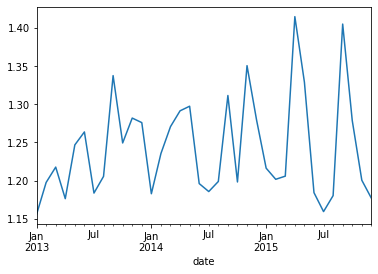

In [36]:
sales_monthly_avg.plot();

In [37]:
sales_monthly_avg.describe()

count    36.000000
mean      1.242899
std       0.066977
min       1.155952
25%       1.193582
50%       1.217052
75%       1.279940
max       1.414705
Name: item_cnt_day, dtype: float64

## Time Series Split

In [43]:
# find the index which allows us to split off 20% of the data
cutoff = round(sales_monthly_avg.shape[0]*0.8)
# Define train and test sets according to the index found above
train = sales_monthly_avg[:cutoff]

test = sales_monthly_avg[cutoff:]

In [44]:
# TimeSeriesSplit
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train):
    print(f'Train index: {train_ind}')
    print(f'Test  index: {val_ind}')

Train index: [0 1 2 3 4 5 6 7 8]
Test  index: [ 9 10 11 12]
Train index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Test  index: [13 14 15 16]
Train index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Test  index: [17 18 19 20]
Train index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Test  index: [21 22 23 24]
Train index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Test  index: [25 26 27 28]


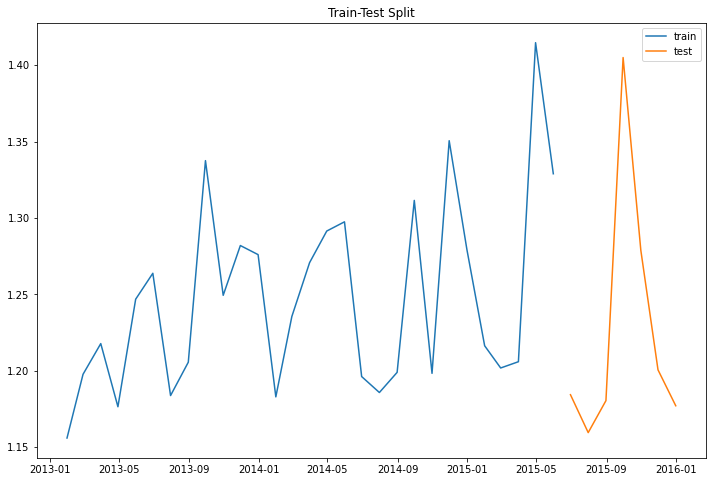

In [45]:
# Plot it!
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

## Modeling

### Baseline

In [52]:
baseline = ARIMA(train, order=(0,0,0)).fit()
bl_preds = baseline.predict(typ='levels')
bl_rmse = np.sqrt(mean_squared_error(train, bl_preds))
b1_aic = baseline.aic
bl_rmse, b1_aic

(0.06119075919151592, -75.7395921666686)

In [53]:
baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           item_cnt_day   No. Observations:                   29
Model:                          ARIMA   Log Likelihood                  39.870
Date:                Sat, 11 Jun 2022   AIC                            -75.740
Time:                        16:31:28   BIC                            -73.005
Sample:                    01-31-2013   HQIC                           -74.883
                         - 05-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2468      0.014     91.987      0.000       1.220       1.273
sigma2         0.0037      0.001      3.209      0.001       0.001       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):                 2.91
Prob(Q):                              0.48   Prob(JB):                         0.23
Heteroskedasticity (H):               1.96   Skew:                             0.78
Prob(H) (two-sided):                  0.30   Kurtosis:                         3.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### A Random Walk

In [54]:
random_walk_model = ARIMA(train, order=(0, 1, 0)).fit()
rw_preds = random_walk_model.predict(typ='levels')
rw_rmse = np.sqrt(mean_squared_error(train, rw_preds))
rw_aic = random_walk_model.aic
rw_rmse, rw_aic

(0.22826451114019922, -60.67467019874634)

In [55]:
random_walk_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           item_cnt_day   No. Observations:                   29
Model:                 ARIMA(0, 1, 0)   Log Likelihood                  31.337
Date:                Sat, 11 Jun 2022   AIC                            -60.675
Time:                        16:33:25   BIC                            -59.342
Sample:                    01-31-2013   HQIC                           -60.267
                         - 05-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0062      0.002      3.918      0.000       0.003       0.009
===================================================================================
Ljung-Box (L1) (Q):                   5.11   Jarque-Bera (JB):                 1.59
Prob(Q):                              0.02   Prob(JB):                         0.45
Heteroskedasticity (H):               2.65   Skew:                             0.58
Prob(H) (two-sided):                  0.16   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### The Autoregressive Model (AR) 

In [56]:
# ar_1 model with differencing
ar_1 = ARIMA(train, order=(1, 1, 0)).fit()
ar_1_preds = ar_1.predict(typ='levels')
ar_1_rmse = np.sqrt(mean_squared_error(train, ar_1_preds))
ar_1_aic = ar_1.aic
ar_1_rmse, ar_1_aic

(0.22610782761226542, -63.52023036371489)

In [57]:
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           item_cnt_day   No. Observations:                   29
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  33.760
Date:                Sat, 11 Jun 2022   AIC                            -63.520
Time:                        16:34:37   BIC                            -60.856
Sample:                    01-31-2013   HQIC                           -62.706
                         - 05-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4014      0.278     -1.446      0.148      -0.945       0.143
sigma2         0.0052      0.001      4.548      0.000       0.003       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):                 3.04
Prob(Q):                              0.50   Prob(JB):                         0.22
Heteroskedasticity (H):               2.38   Skew:                             0.75
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### The Autoregressive Model (AR) 2

In [58]:
# ar_2 model with differencing
ar_2 = ARIMA(train, order=(2, 1, 0)).fit()
ar_2_preds = ar_2.predict(typ='levels')
ar_2_rmse = np.sqrt(mean_squared_error(train, ar_2_preds))
ar_2_aic = ar_2.aic
ar_2_rmse, ar_2_aic

(0.2252901576279512, -63.52964221052318)

In [59]:
ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           item_cnt_day   No. Observations:                   29
Model:                 ARIMA(2, 1, 0)   Log Likelihood                  34.765
Date:                Sat, 11 Jun 2022   AIC                            -63.530
Time:                        16:35:30   BIC                            -59.533
Sample:                    01-31-2013   HQIC                           -62.308
                         - 05-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4985      0.318     -1.570      0.116      -1.121       0.124
ar.L2         -0.2944      0.287     -1.026      0.305      -0.857       0.268
sigma2         0.0048      0.001      4.545      0.000       0.003       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                 4.10
Prob(Q):                              0.64   Prob(JB):                         0.13
Heteroskedasticity (H):               3.41   Skew:                             0.88
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [60]:
train_with_ind = train.reset_index()

In [ ]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(2, 1, 0)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

### Moving Average Model (MA)

In [62]:
ma_1 = ARIMA(train, order=(0, 0, 1)).fit()
ma_1_preds = ma_1.predict(typ='levels')
ma_1_rmse = np.sqrt(mean_squared_error(train, ma_1_preds))
ma_1_aic = ma_1.aic
ma_1_rmse, ma_1_aic

(0.060504752861557064, -74.43093320696724)

In [63]:
ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           item_cnt_day   No. Observations:                   29
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  40.215
Date:                Sat, 11 Jun 2022   AIC                            -74.431
Time:                        16:37:24   BIC                            -70.329
Sample:                    01-31-2013   HQIC                           -73.146
                         - 05-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2467      0.016     78.687      0.000       1.216       1.278
ma.L1          0.1786      0.265      0.673      0.501      -0.341       0.698
sigma2         0.0037      0.001      3.216      0.001       0.001       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 4.40
Prob(Q):                              0.90   Prob(JB):                         0.11
Heteroskedasticity (H):               2.08   Skew:                             0.91
Prob(H) (two-sided):                  0.26   Kurtosis:                         3.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Moving Average Model (MA) 2

In [64]:
ma_2 = ARIMA(train, order=(0, 1, 2)).fit()
ma_2_preds = ma_2.predict(typ='levels')
ma_2_rmse = np.sqrt(mean_squared_error(train, ma_2_preds))
ma_2_aic = ma_2.aic
ma_2_rmse, ma_2_aic

/Users/zachrauch/opt/anaconda3/envs/tf-test/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0.22355855404715627, -68.17813417643383)

In [65]:
ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           item_cnt_day   No. Observations:                   29
Model:                 ARIMA(0, 1, 2)   Log Likelihood                  37.089
Date:                Sat, 11 Jun 2022   AIC                            -68.178
Time:                        16:38:34   BIC                            -64.182
Sample:                    01-31-2013   HQIC                           -66.956
                         - 05-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7311      0.320     -2.286      0.022      -1.358      -0.104
ma.L2         -0.1344      0.303     -0.444      0.657      -0.728       0.459
sigma2         0.0040      0.001      3.859      0.000       0.002       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.40   Jarque-Bera (JB):                 2.29
Prob(Q):                              0.53   Prob(JB):                         0.32
Heteroskedasticity (H):               2.39   Skew:                             0.69
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARMA

In [66]:
arma = ARIMA(train, order=(2, 0, 2)).fit()
arma_preds = arma.predict(typ='levels')
arma_rmse = np.sqrt(mean_squared_error(train, arma_preds))
arma_aic = arma.aic
arma_rmse, arma_aic

/Users/zachrauch/opt/anaconda3/envs/tf-test/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/zachrauch/opt/anaconda3/envs/tf-test/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


(0.05901232922692493, -69.78589048952729)

In [67]:
arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           item_cnt_day   No. Observations:                   29
Model:                 ARIMA(2, 0, 2)   Log Likelihood                  40.893
Date:                Sat, 11 Jun 2022   AIC                            -69.786
Time:                        16:39:09   BIC                            -61.582
Sample:                    01-31-2013   HQIC                           -67.217
                         - 05-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2469      0.017     75.460      0.000       1.215       1.279
ar.L1          0.2829      0.647      0.437      0.662      -0.986       1.551
ar.L2          0.4375      0.599      0.730      0.465      -0.737       1.612
ma.L1         -0.2374      2.914     -0.081      0.935      -5.949       5.475
ma.L2         -0.7474      2.150     -0.348      0.728      -4.962       3.467
sigma2         0.0033      0.009      0.393      0.694      -0.013       0.020
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.40
Prob(Q):                              0.92   Prob(JB):                         0.11
Heteroskedasticity (H):               1.90   Skew:                             0.93
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARIMA

In [68]:
arima = ARIMA(train, order=(2, 1, 2)).fit()
arima_preds = arima.predict(typ='levels')
arima_rmse = np.sqrt(mean_squared_error(train, arima_preds))
arima_aic = arima.aic
arima_rmse, arima_aic

/Users/zachrauch/opt/anaconda3/envs/tf-test/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0.22334668846460715, -64.77607331266323)

In [69]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           item_cnt_day   No. Observations:                   29
Model:                 ARIMA(2, 1, 2)   Log Likelihood                  37.388
Date:                Sat, 11 Jun 2022   AIC                            -64.776
Time:                        16:39:56   BIC                            -58.115
Sample:                    01-31-2013   HQIC                           -62.740
                         - 05-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7014      0.640     -1.096      0.273      -1.956       0.553
ar.L2         -0.0079      0.533     -0.015      0.988      -1.052       1.036
ma.L1         -0.0376      0.639     -0.059      0.953      -1.290       1.214
ma.L2         -0.7253      0.702     -1.033      0.301      -2.101       0.650
sigma2         0.0039      0.001      3.112      0.002       0.001       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):                 1.68
Prob(Q):                              0.58   Prob(JB):                         0.43
Heteroskedasticity (H):               2.54   Skew:                             0.60
Prob(H) (two-sided):                  0.18   Kurtosis:                         2.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### SARIMA 

In [71]:
sarima = SARIMAX(train, order=(2, 1, 2), seasonal_order=(0, 0, 0, 0)).fit()
sarima_preds = sarima.predict(typ='levels')
sarima_rmse = np.sqrt(mean_squared_error(train, sarima_preds))
sarima_aic = sarima.aic
sarima_rmse, sarima_aic

/Users/zachrauch/opt/anaconda3/envs/tf-test/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0.22334668846460715, -64.77607331266323)

In [72]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           item_cnt_day   No. Observations:                   29
Model:               SARIMAX(2, 1, 2)   Log Likelihood                  37.388
Date:                Sat, 11 Jun 2022   AIC                            -64.776
Time:                        16:41:11   BIC                            -58.115
Sample:                    01-31-2013   HQIC                           -62.740
                         - 05-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7014      0.640     -1.096      0.273      -1.956       0.553
ar.L2         -0.0079      0.533     -0.015      0.988      -1.052       1.036
ma.L1         -0.0376      0.639     -0.059      0.953      -1.290       1.214
ma.L2         -0.7253      0.702     -1.033      0.301      -2.101       0.650
sigma2         0.0039      0.001      3.112      0.002       0.001       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):                 1.68
Prob(Q):                              0.58   Prob(JB):                         0.43
Heteroskedasticity (H):               2.54   Skew:                             0.60
Prob(H) (two-sided):                  0.18   Kurtosis:                         2.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Simple Exponential Smoothing (SES)

In [75]:
ses = SimpleExpSmoothing(train).fit()
ses_preds = ses.predict(train.index[0])
ses_rmse = np.sqrt(mean_squared_error(train, ses_preds)) 
ses_aic = ses.aic
ses_rmse, ses_aic

/Users/zachrauch/opt/anaconda3/envs/tf-test/lib/python3.6/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


(0.061190759449667974, -158.03802723440788)

In [76]:
ses.summary()

Dep. Variable:,item_cnt_day,No. Observations:,29
Model:,SimpleExpSmoothing,SSE,0.109
Optimized:,True,AIC,-158.038
Trend:,None,BIC,-155.303
Seasonal:,None,AICC,-156.371
Seasonal Periods:,None,Date:,"Sat, 11 Jun 2022"
Box-Cox:,False,Time:,16:43:29
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.4901e-08,alpha,True
initial_level,1.2468519,l.0,True


### Holt Winter’s Exponential Smoothing (HWES)

In [79]:
hwes = ExponentialSmoothing(train).fit()
hwes_preds = hwes.predict(start=train.index[0], end=train.index[-1])
hwes_rmse = np.sqrt(mean_squared_error(train, hwes_preds)) 
hwes_aic = hwes.aic
hwes_rmse, hwes_aic

/Users/zachrauch/opt/anaconda3/envs/tf-test/lib/python3.6/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


(0.061190759449667974, -158.03802723440788)

In [80]:
hwes.summary()

Dep. Variable:,item_cnt_day,No. Observations:,29
Model:,ExponentialSmoothing,SSE,0.109
Optimized:,True,AIC,-158.038
Trend:,None,BIC,-155.303
Seasonal:,None,AICC,-156.371
Seasonal Periods:,None,Date:,"Sat, 11 Jun 2022"
Box-Cox:,False,Time:,16:44:45
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.4901e-08,alpha,True
initial_level,1.2468519,l.0,True


In [81]:
print(f'B1 RMSE:          {bl_rmse}')
print(f'MA1 RMSE:         {ma_1_rmse}')
print(f'ARMA RMSE:        {arma_rmse}')
print(f'SES RMSE:          {ses_rmse}')
print(f'HWES RMSE:          {hwes_rmse}')

B1 RMSE:          0.06119075919151592
MA1 RMSE:         0.060504752861557064
ARMA RMSE:        0.05901232922692493
SES RMSE:          0.061190759449667974
HWES RMSE:          0.061190759449667974


In [82]:
print(f'B1 AIC: {b1_aic}')
print(f'ma_1 AIC: {ma_1_aic}' )
print(f'arma AIC: {arma_aic}' )
print(f'SES AIC: {ses_aic}' )
print(f'HWES AIC: {hwes_aic}' )

B1 AIC: -75.7395921666686
ma_1 AIC: -74.43093320696724
arma AIC: -69.78589048952729
SES AIC: -158.03802723440788
HWES AIC: -158.03802723440788


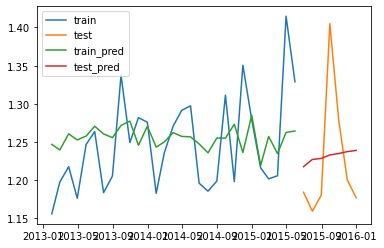

In [83]:
y_hat_train = arma_preds
y_hat_test = arma.predict(start=test.index[0], end=test.index[-1])

fig, ax = plt.subplots()
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_test, label='test_pred')

plt.legend();

In [86]:
test

date
2015-06-30    1.184313
2015-07-31    1.159504
2015-08-31    1.180429
2015-09-30    1.404982
2015-10-31    1.278765
2015-11-30    1.200577
2015-12-31    1.177076
Freq: M, Name: item_cnt_day, dtype: float64

In [87]:
test.index[0]

Timestamp('2015-06-30 00:00:00', freq='M')

In [88]:
test.index[-1]

Timestamp('2015-12-31 00:00:00', freq='M')

In [85]:
sub_set

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648
